In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as L
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torchmetrics


/home2/adyansh/dinner_pool/rsai/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home2/adyansh/dinner_pool/rsai/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# torch.manual_seed(42)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device

In [4]:
# load data from csv
brackets = pd.read_csv('brackets.csv')
brackets.head()

,sequence,stack_depth
0,(((())())((())(()(())(()),-1
1,()(())()((()))()((()()))()(((())()(()))()((())...,16
2,((((()(()(((((()(()())())(()((())((((())))(())...,-1
3,(()(()))()()(((()(((())))))((())(())(()))(((((...,21
4,()(()()()()())()((()))()(()(())()(())())((()()...,3


In [8]:
# create dataloader for training
encode_dict = {'(': [1, 0, 0, 0], ')': [0, 1, 0, 0], '&': [0, 0, 1, 0], '-': [0, 0, 0, 1]}

class BracketDataset(Dataset):
    def __init__(self, data: pd.DataFrame, batch_size=64):
        self.batch_size = batch_size
        
        self.X = data['sequence'].values
        self.stack_depth = data['stack_depth'].values
        self.Y = np.array([[0, 1] if int(y) > 0 else [1, 0] for y in self.stack_depth])
        self.stack_depth = np.abs(self.stack_depth)
        
        self.max_len = max([len(seq) for seq in self.X])
        self.eos_index = np.array([len(seq) for seq in self.X])

        self.X_encoded = np.array([self.encode_sequence(self.pad_sequence(seq)) for seq in self.X])
        
    def encode_sequence(self, seq):
        return np.array([encode_dict[c] for c in seq])
    
    def pad_sequence(self, seq):
        return seq + '&' + '-' * (self.max_len - len(seq))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {'x': self.X_encoded[idx], 'y': self.Y[idx], 'eos': self.eos_index[idx], 'sd': self.stack_depth[idx]}

In [9]:
bracket = BracketDataset(brackets)

In [10]:
bracket[0]

{'x': array([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        ...,
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1]]),
 'y': array([1, 0]),
 'eos': 25,
 'sd': 1}

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """Positional Encoding.

        Args:
            d_model: Hidden dimensionality of the input.
            max_len: Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return x


In [12]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [13]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [14]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3 * embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3)  # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3)  # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [15]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """EncoderBlock.

        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim),
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [16]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = layer(x)
        return attention_maps

In [17]:
train_outbeddings = []
val_outbeddings = []
test_outbeddings = []

In [18]:
class TransformerPredictor(L.LightningModule):
    def __init__(
        self,
        input_dim,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        lr,
        warmup,
        max_iters,
        dropout=0.0,
        input_dropout=0.0,
    ):
        """TransformerPredictor.

        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_classes: Number of classes to predict per sequence element
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            warmup: Number of warmup steps. Usually between 50 and 500
            max_iters: Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()
        self.accuracy = torchmetrics.classification.Accuracy(task="binary")

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout), nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(
            num_layers=self.hparams.num_layers,
            input_dim=self.hparams.model_dim,
            dim_feedforward=2 * self.hparams.model_dim,
            num_heads=self.hparams.num_heads,
            dropout=self.hparams.dropout,
        )
        # Output classifier per sequence element
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes),
        )

    def forward(self, data, mask=None, add_positional_encoding=True):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
            add_positional_encoding: If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = data['x'].float()
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        outbedding = self.transformer(x, mask=mask)
        x = self.output_net(outbedding)
        return x, outbedding

    @torch.no_grad()
    def get_attention_maps(self, data, mask=None, add_positional_encoding=True):
        """Function for extracting the attention matrices of the whole Transformer for a single batch.

        Input arguments same as the forward pass.
        """
        x = data['x']
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # We don't return the lr scheduler because we need to apply it per iteration, not per epoch
        self.lr_scheduler = CosineWarmupScheduler(
            optimizer, warmup=self.hparams.warmup, max_iters=self.hparams.max_iters
        )
        return optimizer

    def optimizer_step(self, *args, **kwargs):
        super().optimizer_step(*args, **kwargs)
        self.lr_scheduler.step()  # Step per iteration
        
    def calc_loss(self, batch, mode='train'):
        x, y = batch['x'], batch['y'].float()
        eos = batch['eos']
        batch['x'] = batch['x'].float()
        y_hat, outbeds = self(batch)
        y_hat = y_hat[torch.arange(y_hat.size(0)), eos]
        outbeds = outbeds[torch.arange(outbeds.size(0)), eos]
        loss = F.cross_entropy(y_hat, y)
        accuracy = self.accuracy(F.softmax(y_hat), y)
        return loss, accuracy, outbeds

    def training_step(self, batch, batch_idx):
        loss, accuracy, outbeds = self.calc_loss(batch, 'train')
        train_outbeddings.append([outbeds.cpu(), batch['sd']])
        self.log('train_loss', loss)
        self.log('train_acc', accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy, outbeds = self.calc_loss(batch, 'val')
        val_outbeddings.append([outbeds.cpu(), batch['sd']])
        self.log('val_loss', loss)
        self.log('val_acc', accuracy, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy, outbeds = self.calc_loss(batch, 'test')
        test_outbeddings.append([outbeds.cpu(), batch['sd']])
        self.log('test_loss', loss)
        self.log('test_acc', accuracy, on_epoch=True)
        return loss
    
    def get_outbeddings(self):
        return self.outbeddings

In [84]:
# divide bracket into train test and val
bracket_size = len(bracket)
train_size = int(0.8 * bracket_size)
val_size = int(0.1 * bracket_size)
test_size = bracket_size - train_size - val_size

train_bracket, val_bracket, test_bracket = torch.utils.data.random_split(bracket, [train_size, val_size, test_size])

train_loader = DataLoader(train_bracket, batch_size=64, shuffle=True, num_workers=39)
val_loader = DataLoader(val_bracket, batch_size=64, num_workers=39)
test_loader = DataLoader(test_bracket, batch_size=64, num_workers=39)

In [85]:
model = TransformerPredictor(input_dim=4, model_dim=128, num_classes=2, num_heads=4, num_layers=1, lr=1e-3, warmup=100, max_iters=1000)
trainer = L.Trainer(max_epochs=10)
trainer.fit(model, train_loader, val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home2/adyansh/dinner_pool/rsai/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home2/adyansh/dinner_pool/rsai/lib/python3.10/site- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 640   
1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_28361/184518823.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  accuracy = self.accuracy(F.softmax(y_hat), y)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [86]:
met = trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_28361/184518823.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  accuracy = self.accuracy(F.softmax(y_hat), y)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9899497628211975     │
│         test_loss         │   0.029701201245188713    │
└───────────────────────────┴───────────────────────────┘

In [87]:
len(train_outbeddings), train_outbeddings[0][0].shape, train_outbeddings[0][1].shape

(5478, torch.Size([64, 128]), torch.Size([64]))

In [88]:
train_outbeddings = [(x.cpu(), y.cpu()) for x, y in train_outbeddings]
val_outbeddings = [(x.cpu(), y.cpu()) for x, y in val_outbeddings]
test_outbeddings = [(x.cpu(), y.cpu()) for x, y in test_outbeddings]

In [96]:
def remove_batch_dimension(outbeddings, stack_depths=[5, 15]):
    outbeds = torch.cat([x[0] for x in outbeddings], dim=0)
    depths = torch.cat([x[1] for x in outbeddings])

    indices = torch.where(torch.isin(depths, torch.tensor(stack_depths)))[0]

    outbeds = outbeds[indices]
    depths = depths[indices]

    return outbeds, depths


In [97]:
X_train_probe, Y_train_probe =  remove_batch_dimension(train_outbeddings)
X_val_probe, Y_val_probe =  remove_batch_dimension(val_outbeddings)
X_test_probe, Y_test_probe =  remove_batch_dimension(test_outbeddings)

In [98]:
X_train_probe.shape, Y_train_probe.shape

(torch.Size([11436, 128]), torch.Size([11436]))

In [99]:
X_train_probe_loader = DataLoader(TensorDataset(X_train_probe.cpu(), Y_train_probe.cpu()), batch_size=64, shuffle=True)
X_val_probe_loader = DataLoader(TensorDataset(X_val_probe.cpu(), Y_val_probe.cpu()), batch_size=64)
X_test_probe_loader = DataLoader(TensorDataset(X_test_probe.cpu(), Y_test_probe.cpu()), batch_size=64)

In [100]:
# class MLPRegressor(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(MLPRegressor, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.activation = nn.ReLU()

#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         x = self.fc2(x)
#         return x
    
#     def train_model(self, X_train, y_train, num_epochs=10, batch_size=32, learning_rate=0.01):
#         criterion = nn.MSELoss()
#         optimizer = optim.AdamW(self.parameters(), lr=learning_rate)
        
#         X_train = X_train.cpu().float()
#         y_train = y_train.cpu().float()
        
#         for epoch in range(num_epochs):
#             for inputs, targets in zip(X_train, y_train):
#                 optimizer.zero_grad()
#                 outputs = self(inputs)
#                 loss = criterion(outputs, targets)
#                 loss.backward(retain_graph=True)
#                 optimizer.step()
#             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#         print("Training finished.")

#     def test_model(self, X_test, y_test):
#         test_dataset = TensorDataset(X_test.cpu())
#         test_loader = DataLoader(test_dataset, batch_size=32)
        
#         predictions = []
#         with torch.no_grad():
#             for inputs in test_loader:
#                 outputs = self(inputs[0])
#                 predictions.extend(outputs.tolist())
        
#         predictions = np.array(predictions)
#         print(f'MSE: {mean_squared_error(y_test.cpu().float(), predictions):.4f}')
#         print(f'MAE: {mean_absolute_error(y_test, predictions):.4f}')
#         print(f'R2: {r2_score(y_test, predictions):.4f}')
#         return predictions

In [101]:
# mlp_probe = MLPRegressor(input_dim=128, hidden_dim=64, output_dim=1)
# mlp_probe.train_model(X_train_probe, Y_train_probe, num_epochs=10, batch_size=32, learning_rate=0.01)

In [107]:
from sklearn.linear_model import LogisticRegression
# import decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


In [129]:

probe = LogisticRegression()
probe.fit(X_train_probe.cpu().detach().numpy(), Y_train_probe.cpu().detach().numpy())

preds = probe.predict(X_test_probe.cpu().detach().numpy())

print(classification_report(Y_test_probe.cpu().detach().numpy(), preds))

In [106]:
probe = DecisionTreeClassifier()
probe.fit(X_train_probe.cpu().detach().numpy(), Y_train_probe.cpu().detach().numpy())

preds = probe.predict(X_test_probe.cpu().detach().numpy())

print(classification_report(Y_test_probe.cpu().detach().numpy(), preds))

              precision    recall  f1-score   support

           5       0.52      0.55      0.54        65
          15       0.85      0.83      0.84       200

    accuracy                           0.77       265
   macro avg       0.69      0.69      0.69       265
weighted avg       0.77      0.77      0.77       265



In [108]:
probe = MLPClassifier(hidden_layer_sizes=(64,), max_iter=1000)
probe.fit(X_train_probe.cpu().detach().numpy(), Y_train_probe.cpu().detach().numpy())

preds = probe.predict(X_test_probe.cpu().detach().numpy())

print(classification_report(Y_test_probe.cpu().detach().numpy(), preds))

              precision    recall  f1-score   support

           5       0.61      0.55      0.58        65
          15       0.86      0.89      0.87       200

    accuracy                           0.80       265
   macro avg       0.73      0.72      0.73       265
weighted avg       0.80      0.80      0.80       265



In [128]:
probe = MLPClassifier(hidden_layer_sizes=(64,128), max_iter=1000)
probe.fit(X_train_probe.cpu().detach().numpy(), Y_train_probe.cpu().detach().numpy())

preds = probe.predict(X_test_probe.cpu().detach().numpy())

print(classification_report(Y_test_probe.cpu().detach().numpy(), preds))

              precision    recall  f1-score   support

           5       0.65      0.63      0.64        65
          15       0.88      0.89      0.89       200

    accuracy                           0.83       265
   macro avg       0.77      0.76      0.76       265
weighted avg       0.82      0.83      0.83       265



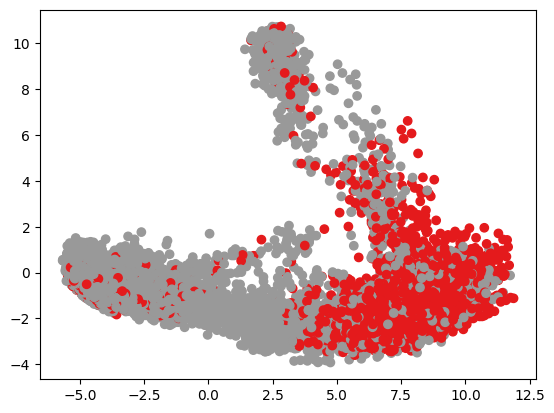

In [127]:
# do pca on outbeddings
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_train_probe_pca = pca.fit_transform(X_train_probe.cpu().detach().numpy())

plt.scatter(X_train_probe_pca[:, 0], X_train_probe_pca[:, 1], c=Y_train_probe.cpu().detach().numpy(), cmap='Set1')
plt.show()